**Nombre**: Renzo Tassara Miller
___

En la siguiente tarea se contrastan distintas implementaciones de K-Means y se observan sus runtimes. 
- Este Informe/Reporte junto al código entregado responden a todas las solicitudes de la tarea.

A continuación se encuentran implementadas 5 versiones del algoritmo + la versión de scikit-learn. Estas son:

- `Scikit`: Versión de K-Means proveniente de `sklearn.clusters`.
- `Numpy`: Algoritmo K-Means implementado únicamente usando `numpy`.
- `Python`: K-Means implementado únicamente con Python "puro", es decir se utilizan solamente loops nativos de python y list comprehensions.

Se crearon 3 versiones de `Python` con operaciones paralelizadas con `multiprocessing`:
- `Par-K`: Versión de `Python` que únicamente paraleliza el cálculo de las distancias euclideanas **respecto a cada centroide (K)**. `argmin` se calcula linealmente.
- `Par-Chunks`: Versión de `Python` que divide el dataset en la cantidad de procesadores a utilizar (chunks) y calcula los clusters de cada segmento para finalmente unir todo.
- `Par-Rows`: Versión de `Python` que calcula los clusters de manera paralela por fila, es decir, si se disponibilizan 8 procesadores, se procesarán 8 filas de manera paralela (1 fila por proceso)
___

Las implementaciones de K-means se encuentran en: `kmeans.py`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import run_kmeans
import pickle
import multiprocessing

In [2]:
print('Physical Cores:', multiprocessing.cpu_count() // 2)
print('Logical Cores:', multiprocessing.cpu_count())

Physical Cores: 8
Logical Cores: 16


## Benchmark

Se creó un Benchmark que ejecuta desde 2 hasta 8 procesos (El máximo de cores físicos del computador donde ocurrió la ejecución) sobre 2 datasets creados por `make_blobs`. Uno pequeño de `1.000` filas y otro de `50.000` filas.

- `Scikit`, `Numpy` y `Python` se ejecutan una sola vez y el valor obtenido se repite en cada punto de la gráfica. Esto se debe a que estas 3 implementaciones no dependen de `multiprocessing`
- `Par-K`, `Par-Chunks` y `Par-Rows` si son ejecutados en cada iteración para distintas cantidades de procesadores.

El script de Benchmark se encuentra en `benchmarks.py` y a continuación se muestra su output correspondiente a un archivo `benchmark.pickle`: 

In [3]:
with open('benchmark.pickle', 'rb') as f:
    benchmark = pickle.load(f)

In [4]:
static = ['Numpy', 'Scikit', 'Python']
sm_bm = pd.DataFrame(benchmark['small']).melt(id_vars='n_proc')
lg_bm = pd.DataFrame(benchmark['large']).melt(id_vars='n_proc')

static_sm_bm = sm_bm[sm_bm.variable.isin(static)]
proc_sm_bm = sm_bm[~sm_bm.variable.isin(static)]

static_lg_bm = lg_bm[lg_bm.variable.isin(static)]
proc_lg_bm = lg_bm[~lg_bm.variable.isin(static)]

speedup_bm = pd.concat([proc_lg_bm, lg_bm[lg_bm.variable.isin(['Numpy', 'Scikit'])].iloc[:, 1:3].drop_duplicates()], axis=0)
speedup_bm = speedup_bm.rename(columns={'value':'runtime', 'variable':'model'})
base_runtime = static_lg_bm[static_lg_bm.variable == 'Python'].value.iloc[0] / speedup_bm.runtime
speedup_bm['speedup'] = base_runtime
speedup_bm = speedup_bm.sort_values('speedup', ascending=False).fillna(1).reset_index(drop=True)
speedup_bm.n_proc = speedup_bm.n_proc.astype(int)

In [5]:
static_sm_bm[['variable', 'value']].drop_duplicates().reset_index(drop=True).style.format({'value':"{:.3f} Secs"})

,variable,value
0,Numpy,0.004 Secs
1,Scikit,0.007 Secs
2,Python,0.243 Secs


In [6]:
static_lg_bm[['variable', 'value']].drop_duplicates().reset_index(drop=True).style.format({'value':"{:.3f} Secs"})

,variable,value
0,Numpy,1.924 Secs
1,Scikit,0.044 Secs
2,Python,77.836 Secs


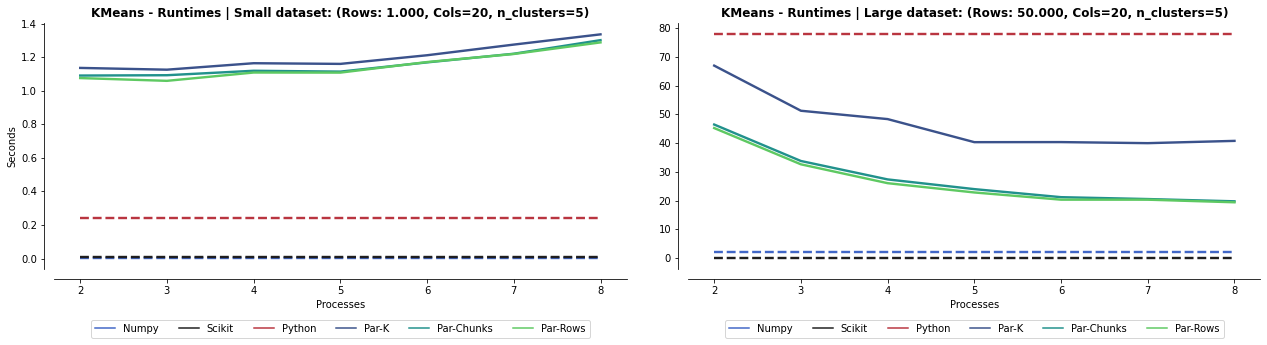

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), facecolor='white')
sns.lineplot(data = static_sm_bm, x='n_proc', y='value', hue='variable', linewidth=2.4, palette='icefire', ax=ax[0])
sns.lineplot(data = proc_sm_bm, x='n_proc', y='value', hue='variable', linewidth=2.4, palette='viridis', ax=ax[0])
for n in range(3):
    ax[0].lines[n].set_linestyle('--')
ax[0].set_xlabel('Processes')
ax[0].set_ylabel('Seconds')
ax[0].set_title('KMeans - Runtimes | Small dataset: (Rows: 1.000, Cols=20, n_clusters=5)', weight='bold')
ax[0].legend(loc='lower center', ncol=6, bbox_to_anchor=(.5, -0.3))

sns.lineplot(data = static_lg_bm, x='n_proc', y='value', hue='variable', linewidth=2.4, palette='icefire', ax=ax[1])
sns.lineplot(data = proc_lg_bm, x='n_proc', y='value', hue='variable', linewidth=2.4, palette='viridis', ax=ax[1])
for n in range(3):
    ax[1].lines[n].set_linestyle('--')
ax[1].set_xlabel('Processes')
ax[1].set_ylabel(None)
ax[1].set_title('KMeans - Runtimes | Large dataset: (Rows: 50.000, Cols=20, n_clusters=5)', weight='bold')
ax[1].legend(loc='lower center', ncol=6, bbox_to_anchor=(.5, -0.3))
sns.despine(offset=10)
plt.tight_layout()
plt.show()

**Top 10 Speedup (Large Dataset)**

In [8]:
speedup_bm.head(10).style.format({'runtime':'{:.2f} Secs',
                                  'speedup':'{:.2f}'})

,n_proc,model,runtime,speedup
0,1,Scikit,0.04 Secs,1787.83
1,1,Numpy,1.92 Secs,40.46
2,8,Par-Rows,19.39 Secs,4.02
3,8,Par-Chunks,19.73 Secs,3.95
4,7,Par-Rows,20.30 Secs,3.84
5,6,Par-Rows,20.30 Secs,3.83
6,7,Par-Chunks,20.51 Secs,3.79
7,6,Par-Chunks,21.17 Secs,3.68
8,5,Par-Rows,22.80 Secs,3.41
9,5,Par-Chunks,23.97 Secs,3.25


**Small Dataset: 1.000 Rows**:
- Las versiones de `Numpy` y `Scikit` se ejecutan rápidamente con tiempos cercanos a 0 (0.004 secs  y 0.007 secs) respectivamente.

- Las versiones paralelas `Par-K`, `Par-Chunks` y `Par-Rows` se ejecutan más lentamente que la versión `Python` (no paralelizada) . Mientras más procesadores se agreguen a la ejecución, más lento corre.
    - Esto se debe a que existe un overhead para iniciar cada proceso. Como el problema es de baja complejidad, el iniciar nuevos procesos hace más lenta la ejecución del modelo.
    
**Large Dataset: 50.000 Rows**
- `Scikit` Se mantiene como la implementación más eficiente seguida por el modelo construido en numpy por lo que se puede percibir los beneficios de vectorización.
- El modelo construido únicamente con `Python` de ejecución lineal se ejecuta considerablemente lento en relación a los otros 2 modelos sin multiprocessing. Los for loops / nested for loops de Python e iterar sobre listas suelen ser operaciones lentas.

- `Par-K` Muestra mejoras de rendimiento por cada proceso adicional agregado. Sin embargo ya que este proceso solamente realiza de manera paralela el cálculo de las distancias euclideanas respecto a cada centro, el tener más procesos que centros no mejorará el runtime del modelo ya que todos los centroides ya se encuentran funcionando de manera paralela. Esto se percibe en las gráficas a partir de $Processes > 5$.

- `Par-Chunks` Esta versión de modelo paralelizado divide el dataset en la cantidad de procesos y calcula los clusters de manera independiente para finalmente unir los resultados. Se observa que a medida incrementa la cantidad de procesos el modelo corre en menos tiempo, siendo así mucho más eficiente en velocidad de computo que su versión no paralela `Python`. El rendimiento adicional por procesador incrementa cada vez en menores cantidades. Esto se debe a que existe un punto en que más procesadores no van a lograr mejorar los tiempos de ejecución (por ejemplo: infinitos procesadores) y el runtime dependerá únicamente de la o las secciones de ejecución lineal del modelo.

- `Par-Rows` Se observa que tiene un comportamiento similar al de `Par-Chunks` pero ejecuta ligeramente más rápido lo que puede ser debido a que definitivamente es más eficiente ejecutar todas las filas de manera paralela que dividir el dataset en chunks o que el tiempo adicional se debe a los procesos de división del dataset en chunks y a la operación de reshaping de los clusters que se realizan.

$---$<br>
Se puede concluir que en pocos datos o en problemas de carga muy liviana `multiprocessing` resulta ineficiente ya que el costo de abrir nuevos procesos resulta muy alto en respecto al beneficio que ofrece la paralelización de procesos, sin embargo, cuando nos encontramos frente a problemas de alta dimensionalidad y/o muchos datos el paralelizar operaciones entrega grandes mejoras en los tiempos de ejecución.
___

## K-Means:

A continuación se ejecuta el script `run_kmeans.py` y se utilizará el resultado de este para generar las gráficas y aplicar PCA
<br>$---$

Se crea un dataset utilizando `make_blobs` con:
- `100.000` filas
- `25` Columnas
- `5` Clusters


Se ejecutan las distintas versiones de K-Means a continuación:

In [9]:
with open("run_kmeans.py", 'r') as f:
    exec(f.read())

Dataset shape: (100000, 25)
n_clusters: 5
processors: 8

Numpy took: 0.20 Seconds to run
Python took: 8.13 Seconds to run
- Parallelized models:
Par-K took: 4.55 Seconds to run
Par-Chunks took: 2.63 Seconds to run
Par-Rows took: 2.56 Seconds to run
---
KMeans-scikit took: 0.05 Seconds to run
---

Trained K-Means algorithms saved in variable: fitted_kmeans


Se recupera de la ejecución la variable `fitted_kmeans` que contiene las 5 versiones de `K-Means` + versión de `Scikit`:

In [10]:
fitted_kmeans.keys()

dict_keys(['Numpy', 'Python', 'Par-K', 'Par-Chunks', 'Par-Rows', 'Scikit'])

- Las 5 versiones + `Scikit` entregan los mismos resultados y utilizan la misma cantidad de iteraciones ya que inician con los mismos centroides iniciales.
- A continuación utilizaremos únicamente la versión `Par-Rows` para gráficar los resultados.

In [11]:
kmeans = fitted_kmeans['Par-Rows'] 

In [12]:
print('Convergance on iteration:', kmeans.convergence)
print('Sample 10 first clusters:', kmeans.clusters[0:10])

Convergance on iteration: 2
Sample 10 first clusters: [1, 2, 2, 2, 2, 3, 0, 2, 1, 2]


- Se observa que el algoritmo ejecuta relativamente rápido para este dataset ya que converge en solo 2 iteraciones.

## PCA y Gráficas

Ya que los datos utilizados tienen más de 2 features se aplica PCA de 2 componentes para posteriormente graficar.

In [13]:
pca = PCA(n_components = 2)
pca.fit(df)
df_pca = pd.DataFrame(pca.transform(df), columns=['Comp1', 'Comp2'])
df_pca['Clusters'] = kmeans.clusters

centers = pd.DataFrame(pca.transform(kmeans.centers), columns=['Comp1', 'Comp2'])

In [14]:
df_pca.head()

,Comp1,Comp2,Clusters
0,10.074980,2.759294,1
1,-18.858934,-15.520246,2
2,-18.123258,-15.066978,2
3,-18.689039,-14.375315,2
4,-18.049518,-14.767406,2


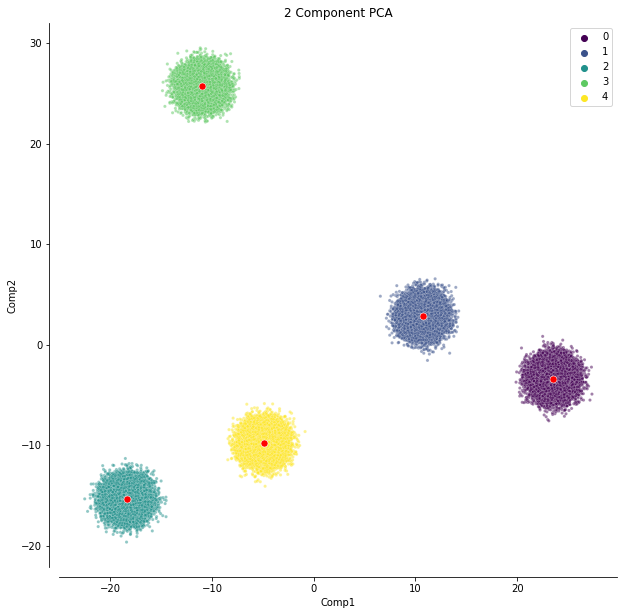

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
sns.scatterplot(data=df_pca, x='Comp1', y='Comp2', hue='Clusters', ax=ax, palette='viridis', alpha=0.5, s=10)
sns.scatterplot(data=centers, x='Comp1', y='Comp2', color='red', ax=ax, s=50)
ax.set_title('2 Component PCA')
sns.despine(offset=10)
plt.show()

___